In [51]:
import pandas as pd

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

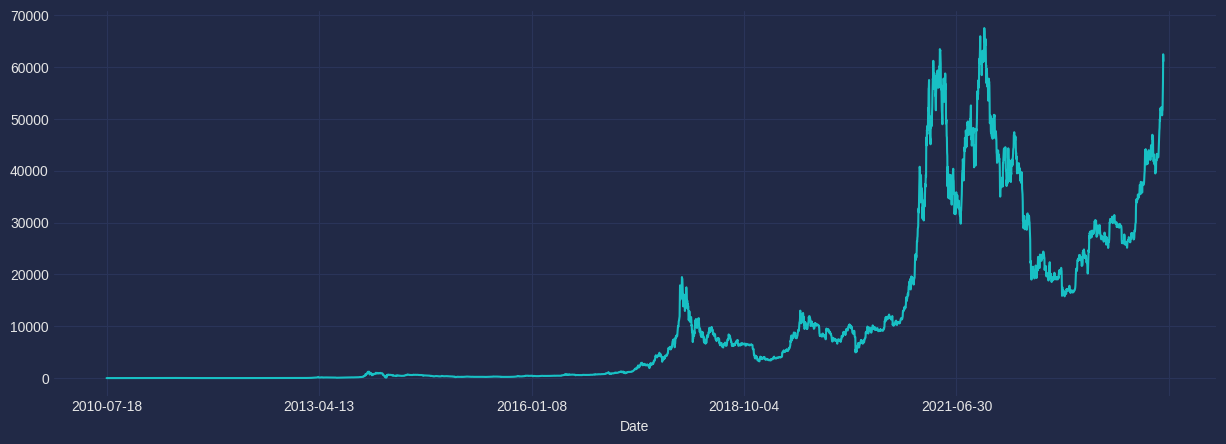

In [15]:
df = pd.read_csv('btc.csv', index_col=0)
df.Close.plot(figsize=(15, 5));

Train-test split

In [74]:
#n = len(df)
#train_df = df[0:int(n*0.7)]
#val_df = df[int(n*0.7):int(n*0.9)]
#test_df = df[int(n*0.9):]

train_df = df.reset_index().Close[1000:4500].to_frame()
val_df = df.reset_index().Close[4500:4750].to_frame()
test_df = df.reset_index().Close[4750:].to_frame()

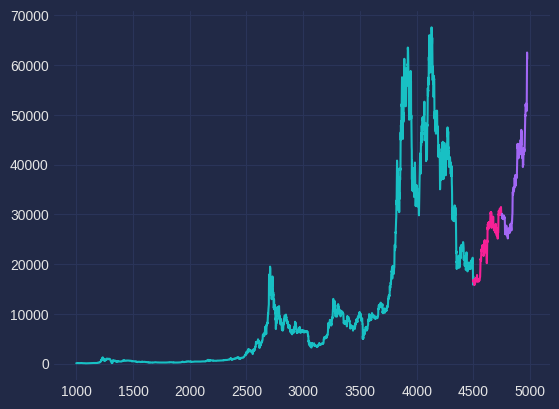

In [77]:
plt.plot(train_df)
plt.plot(val_df)
plt.plot(test_df);

In [52]:
transformers = [
    #('poly', PolynomialFeatures(2), ['Close']),
    ('power', PowerTransformer(method='box-cox', standardize=False), ['Close']),
    ('scale', MinMaxScaler(feature_range=(1, 10)), ['Close'])]

preprocessor = ColumnTransformer(transformers)

In [53]:
preprocessor

ColumnTransformer(transformers=[('power',
                                 PowerTransformer(method='box-cox',
                                                  standardize=False),
                                 ['Close']),
                                ('scale', MinMaxScaler(feature_range=(1, 10)),
                                 ['Close'])])

In [83]:
tr_tr = preprocessor.fit_transform(train_df)
val_tr = preprocessor.transform(val_df)
test_tr = preprocessor.transform(test_df)

train_df = pd.DataFrame(data=tr_tr[:,0], columns=['Close'], index=train_df.index)
val_df = pd.DataFrame(data=val_tr[:,0], columns=['Close'], index=val_df.index)
test_df = pd.DataFrame(data=test_tr[:,0], columns=['Close'], index=test_df.index)

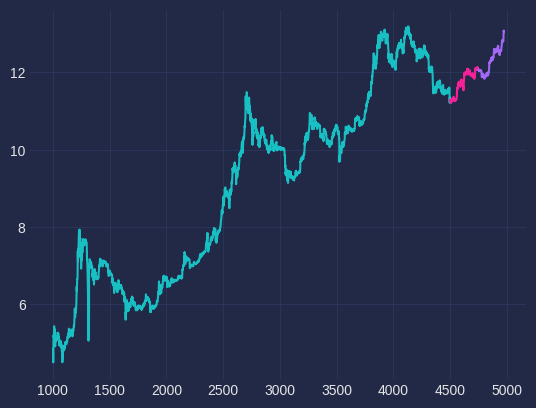

In [86]:
plt.plot(train_df)
plt.plot(val_df)
plt.plot(test_df);

## Preparing the data for the NN

In [92]:
import tensorflow as tf

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


In [103]:
w1 = WindowGenerator(input_width=100, label_width=10, shift=10,
                     label_columns=['Close'])
w1

Total window size: 110
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
Label indices: [100 101 102 103 104 105 106 107 108 109]
Label column name(s): ['Close']

In [104]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 110, 1)
Inputs shape: (3, 100, 1)
Labels shape: (3, 10, 1)


In [105]:
w1.example = example_inputs, example_labels

In [108]:
def plot(self, model=None, plot_col='Close', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [days]')


WindowGenerator.plot = plot


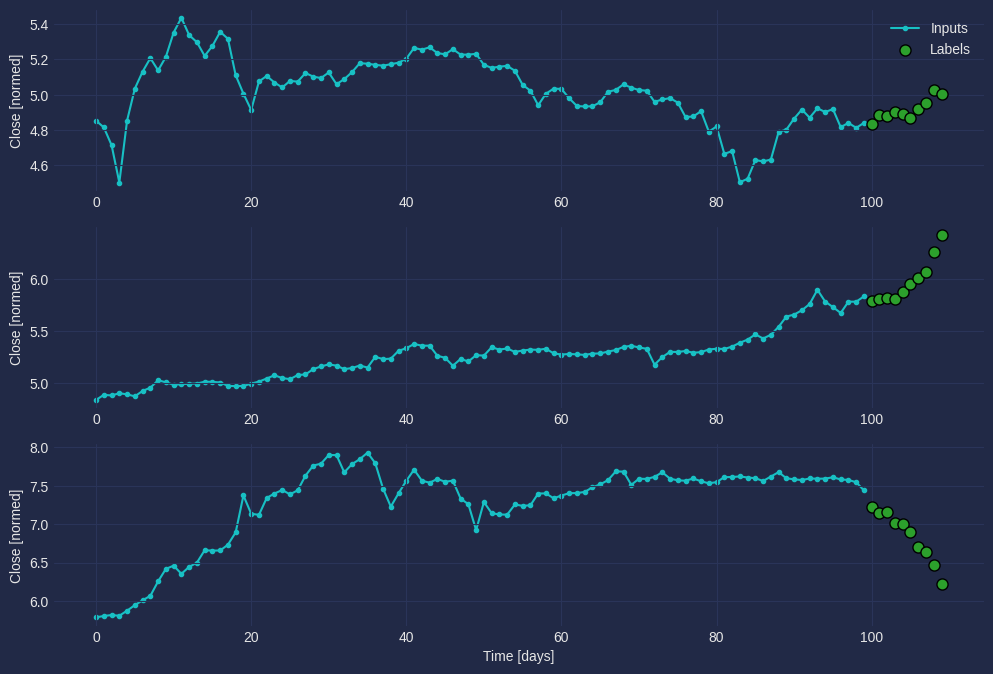

In [109]:
w1.plot()

In [110]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [111]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [112]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10, 1), dtype=tf.float32, name=None))

In [113]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 100, 1)
Labels shape (batch, time, features): (32, 10, 1)


# Single step models

Configuring the `Window generator` object for a single step model (just one step into the future):

In [114]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Close'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Close']

In [115]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Baseline model

In [116]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]


Initiate and evaluate the Baseline model

In [119]:
baseline = Baseline(label_index=0)

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)

8/8 [==============================] - 1s 18ms/step - loss: 9.7996e-04 - mean_absolute_error: 0.0216


### Wide window

In [120]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['Close'])

wide_window


Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['Close']

In [121]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


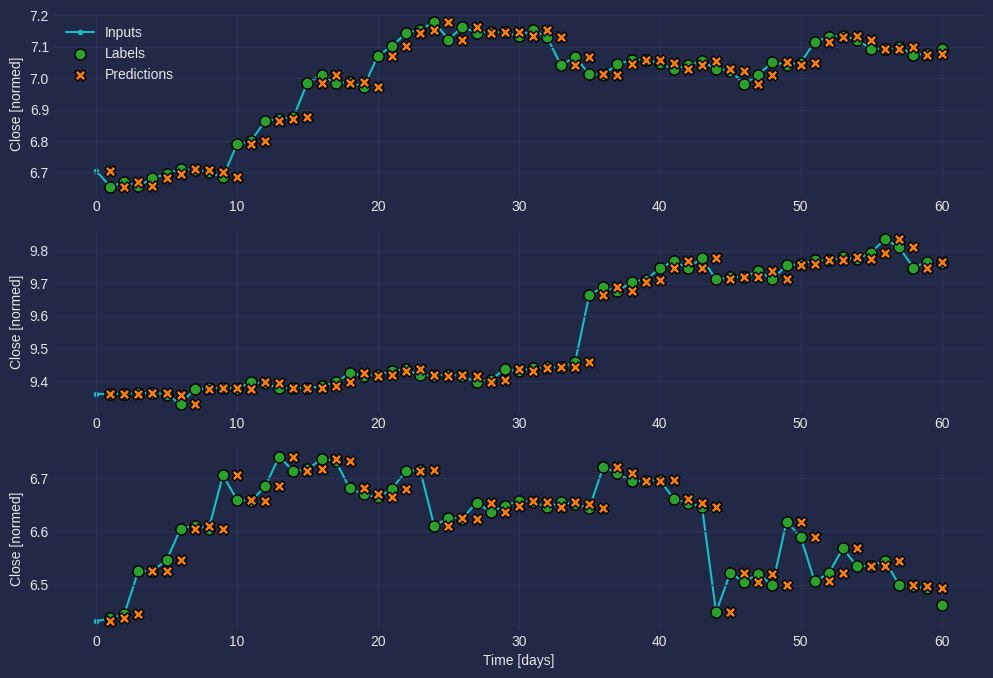

In [122]:
wide_window.plot(baseline)

# Trainable models

In [125]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


## Linear model

No interaction between single prediction along the window

In [126]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)


Epoch 1/20
110/110 [==============================] - 1s 5ms/step - loss: 20.8507 - mean_absolute_error: 4.3990 - val_loss: 25.5302 - val_mean_absolute_error: 5.0509
Epoch 2/20
110/110 [==============================] - 1s 4ms/step - loss: 12.5664 - mean_absolute_error: 3.4055 - val_loss: 15.0570 - val_mean_absolute_error: 3.8788
Epoch 3/20
110/110 [==============================] - 0s 4ms/step - loss: 7.1059 - mean_absolute_error: 2.5499 - val_loss: 8.3426 - val_mean_absolute_error: 2.8870
Epoch 4/20
110/110 [==============================] - 1s 6ms/step - loss: 3.7387 - mean_absolute_error: 1.8373 - val_loss: 4.3150 - val_mean_absolute_error: 2.0761
Epoch 5/20
110/110 [==============================] - 1s 5ms/step - loss: 1.8169 - mean_absolute_error: 1.2668 - val_loss: 2.0818 - val_mean_absolute_error: 1.4417
Epoch 6/20
110/110 [==============================] - 0s 4ms/step - loss: 0.8134 - mean_absolute_error: 0.8309 - val_loss: 0.9408 - val_mean_absolute_error: 0.9687
Epoch 7/20
1

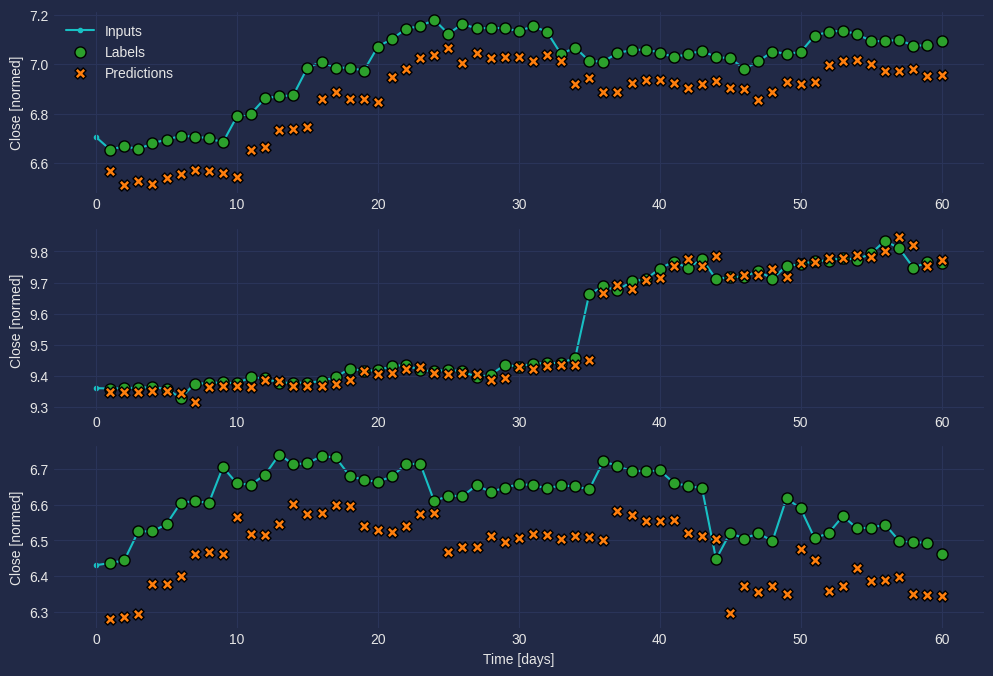

In [127]:
wide_window.plot(linear)


## Dense

In [128]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)


Epoch 1/20
110/110 [==============================] - 3s 10ms/step - loss: 5.8088 - mean_absolute_error: 1.2661 - val_loss: 0.0038 - val_mean_absolute_error: 0.0544
Epoch 2/20
110/110 [==============================] - 1s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0708 - val_loss: 0.0041 - val_mean_absolute_error: 0.0567
Epoch 3/20
110/110 [==============================] - 0s 4ms/step - loss: 0.0084 - mean_absolute_error: 0.0677 - val_loss: 0.0030 - val_mean_absolute_error: 0.0462
Epoch 4/20
110/110 [==============================] - 1s 5ms/step - loss: 0.0078 - mean_absolute_error: 0.0639 - val_loss: 0.0026 - val_mean_absolute_error: 0.0422
Epoch 5/20
110/110 [==============================] - 1s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0599 - val_loss: 0.0019 - val_mean_absolute_error: 0.0347
Epoch 6/20
110/110 [==============================] - 1s 5ms/step - loss: 0.0067 - mean_absolute_error: 0.0563 - val_loss: 0.0013 - val_mean_absolute_error: 0.0268
Epoch 7/20
110/

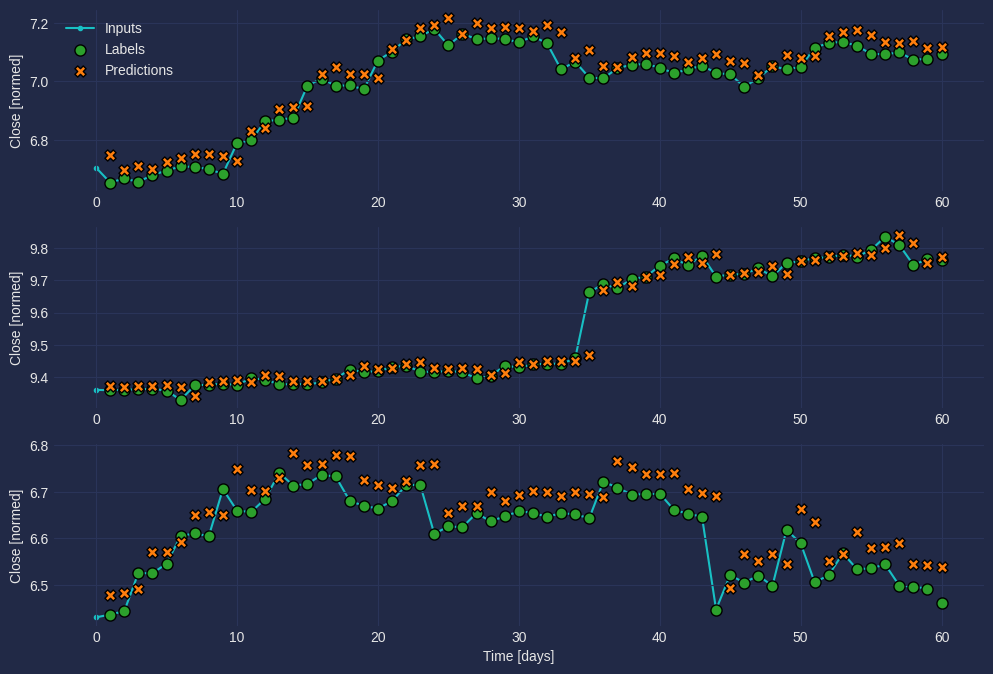

In [130]:
wide_window.plot(dense)


## Multi-step dense

In [131]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Close'])

conv_window


Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Close']

Demonstration of how the model will work

Text(0.5, 0.98, 'Given 3 days of inputs, predict 1 day into the future.')

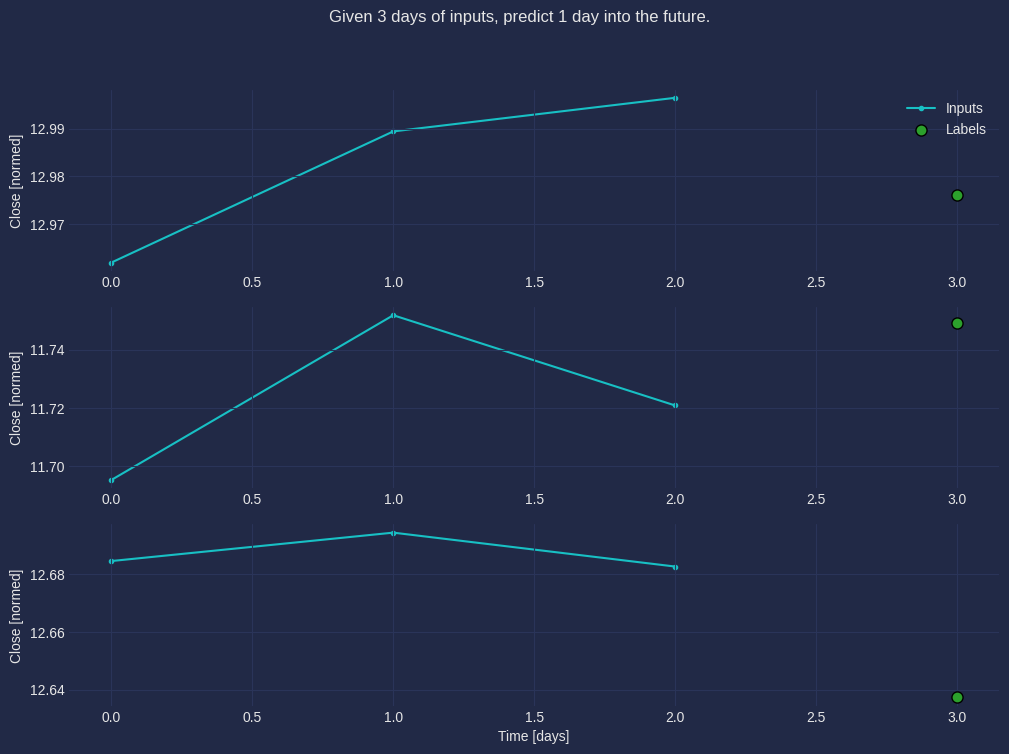

In [132]:
conv_window.plot()
plt.suptitle("Given 3 days of inputs, predict 1 day into the future.")


In [134]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [137]:
import IPython
import IPython.display

In [138]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)


8/8 [==============================] - 0s 2ms/step - loss: 0.0028 - mean_absolute_error: 0.0422


# Recurrent neural network - LSTM

In [140]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


In [141]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)


6/6 [==============================] - 0s 9ms/step - loss: 0.1101 - mean_absolute_error: 0.0816


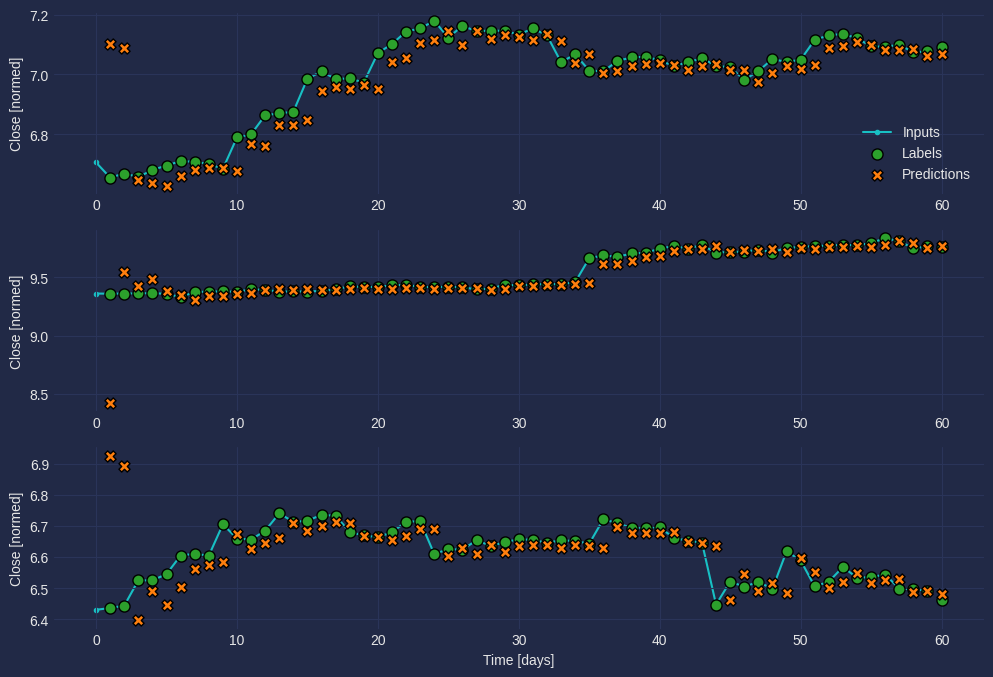

In [142]:
wide_window.plot(lstm_model)


# Model comparison

In [143]:
cm = lstm_model.metrics[1]
cm.metrics

[]

In [144]:
val_performance


{'Baseline': {'loss': 0.0009799579856917262,
  'mean_absolute_error': 0.021602852270007133},
 'Linear': {'loss': 0.011032712645828724,
  'mean_absolute_error': 0.09951528161764145},
 'Dense': {'loss': 0.001453345874324441,
  'mean_absolute_error': 0.028791463002562523},
 'Multi step dense': {'loss': 0.0027665465604513884,
  'mean_absolute_error': 0.0421840138733387},
 'LSTM': {'loss': 0.11012835055589676,
  'mean_absolute_error': 0.08160637319087982}}

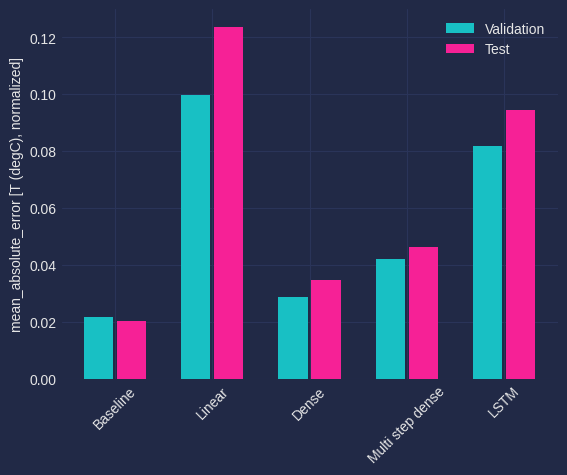

In [145]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [156]:
lstm_pred = lstm_model.predict(wide_window.test)

6/6 [==============================] - 0s 8ms/step


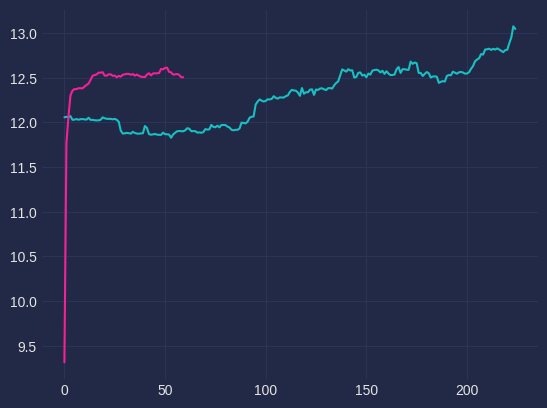

In [161]:
plt.plot(test_tr[:, 0])
plt.plot(lstm_pred[0])

# Multi_window models

---

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): None

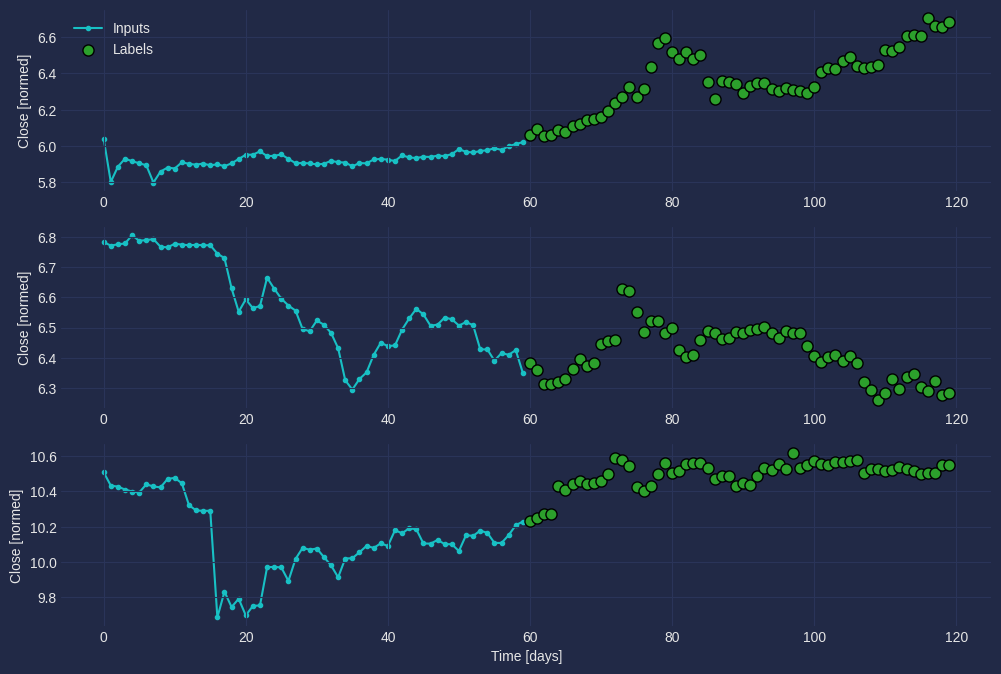

In [147]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=60,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window


## Baseline

5/5 [==============================] - 0s 6ms/step - loss: 0.0292 - mean_absolute_error: 0.1298


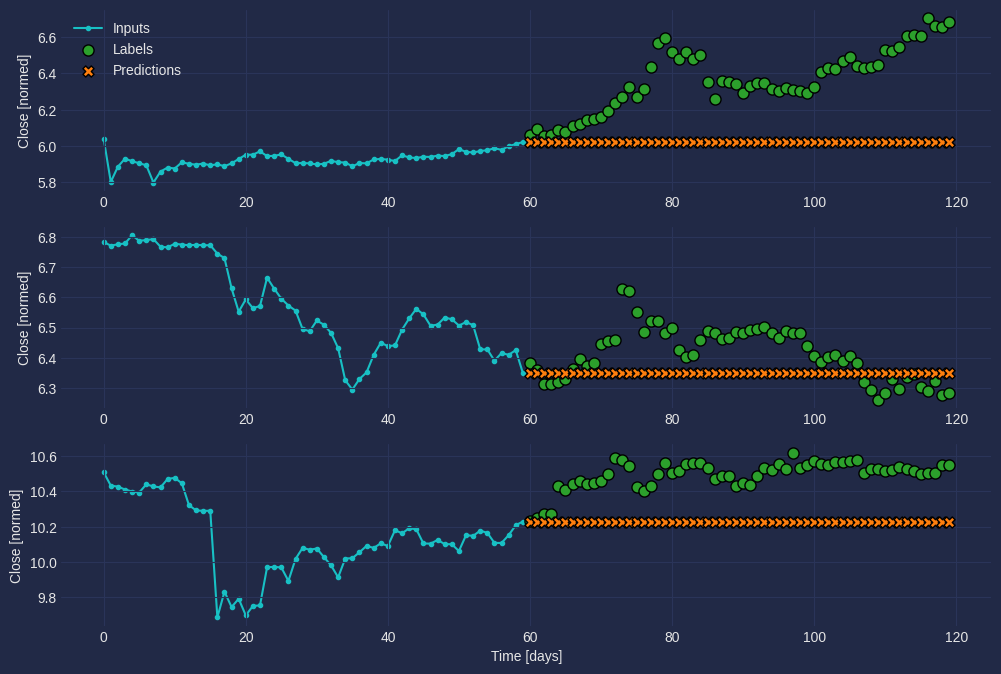

In [150]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val, return_dict=True)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(last_baseline)


## RNN - LSTM

5/5 [==============================] - 0s 11ms/step - loss: 0.0290 - mean_absolute_error: 0.1453


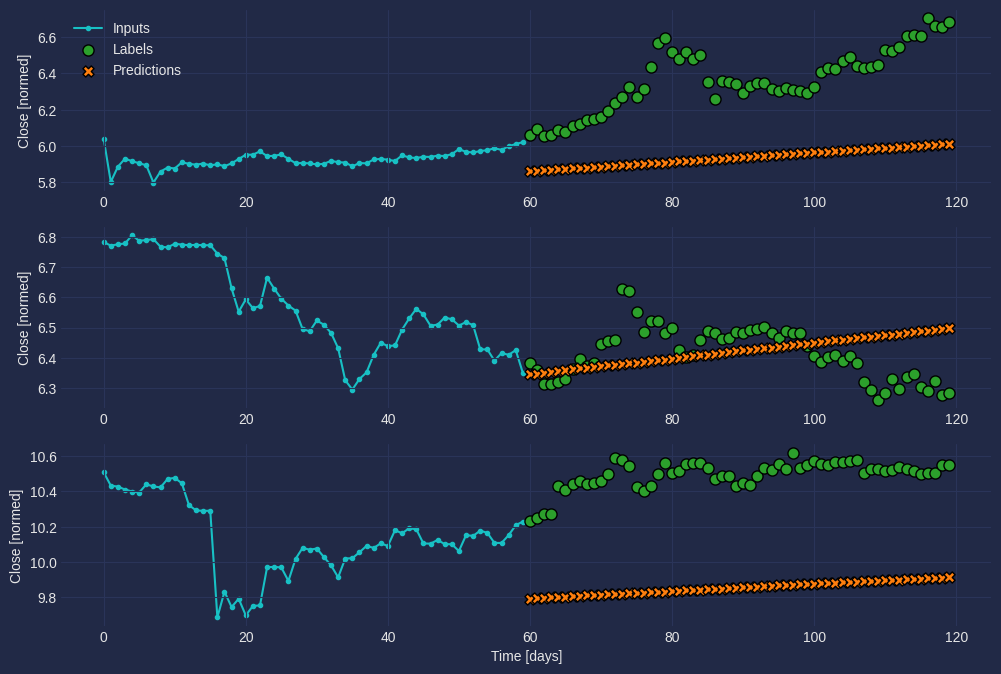

In [151]:
num_features=1

multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0, return_dict=True)
multi_window.plot(multi_lstm_model)


# The tutorial on youtibe

https://youtu.be/QIUxPv5PJOY



In [ ]:
for i in range(60, len(train_df)):



In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape(x_train.shape)))
